In [1]:
import numpy as np
import pandas as pd
import glob
import pickle
import os

from os import walk
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler, StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score,  fbeta_score, auc
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from livelossplot.tf_keras import PlotLossesCallback
%matplotlib inline
# %matplotlib notebook

Using TensorFlow backend.


In [2]:
# PATH
path = ('C:/Users/hasegawa-lab-pc/OneDrive - Japan Advanced Institute of Science and Technology/Documents/Dataset/DAiSEE/OpenFace_2.2.0_win_x64/processed/csv/')

path_subj = path+'Csv_per_subject/'
subj = os.listdir(path+'Csv_per_subject/')
subjx = [] #List of X per subject (features)
subjy = [] #List of Y per subject (label)
for i in range(len(subj)):
    subjx.append('X_%s' % subj[i])
    subjy.append('Y_%s' % subj[i])

path_lbl_subj = path+'labels/label_subject/'
lbl_subj = []
for (lbl_dirpath, dirname, filename) in walk(path_lbl_subj):
    lbl_subj.extend(filename) 

input_path = ('C:/Users/hasegawa-lab-pc/OneDrive - Japan Advanced Institute of Science and Technology/Documents/Exp_Shofi/Preprocess and Statistical Analysis/extracted/')

In [ ]:
# LOAD DATA Per Subject (for Testing)
for i in range(len(subj)):
    with open(path+'extracted/EHA_'+subj[i]+'.pkl','rb') as f:
        globals()[subjx[i]], globals()[subjy[i]] = pickle.load(f)

In [3]:
# LOAD Training set
# with open(input_path+'daisee_EHA.pkl','rb') as f:
#     X_train_eye, X_val_eye, X_test_eye, X_train_head, X_val_head, X_test_head, X_train_au, X_val_au, X_test_au, Y_train, Y_val,  Y_test= pickle.load(f)
# # stack features
# X_train = np.dstack((X_train_eye,X_train_head,X_train_au))
# X_val = np.dstack((X_val_eye,X_val_head,X_val_au))
# X_test = np.dstack ((X_test_eye,X_test_head,X_test_au))

# with open(input_path+'daisee_329dims_10timesteps.pkl','rb') as f:
#     X_train_all, X_val_all, X_test_all, X_train_all_scalled, X_val_all_scalled, X_test_all_scalled,Y_train, Y_val, Y_test = pickle.load(f)
    
# X_train = X_train_all
# X_val = X_val_all
# X_test = X_test_all

# with open(input_path+'daisee_28_186.pkl','rb') as f:
with open(input_path+'daisee_31_51.pkl','rb') as f:
    X_train, X_val, X_test, y_train, y_val, y_test = pickle.load(f)
print(X_train.shape,X_val.shape,X_test.shape)

# with open(input_path+'emotiw_186.pkl','rb') as f:
#     X, y = pickle.load(f)

(5467, 51, 31) (1703, 51, 31) (1782, 51, 31)


In [4]:
# # APPEND ALL X and Y
X = np.concatenate((X_train, X_val, X_test), axis=0)
y = np.concatenate((y_train, y_val, y_test), axis=0)

print(X.shape, y.shape)

(8952, 51, 31) (8952,)


In [5]:
# To Categorical
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)
y_cat = to_categorical(y)
# print(Y_cat)

In [6]:
# SCALLING
# X = X_pca
# scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
print(X.shape)

# for i in range(len(subj)):
#     globals()[subjx[i]] = scaler.transform(globals()[subjx[i]].reshape(-1, globals()[subjx[i]].shape[-1])).reshape(globals()[subjx[i]].shape)
#     # print(subjx[i])

# X_reshaped = X.reshape((X.shape[0]*X.shape[1], X.shape[2])) 
# scaler.fit(X_reshaped)
# X_reshaped = scaler.transform(X_reshaped)

(8952, 51, 31)


In [ ]:
# # PCA
# X_train_reshaped = X_train.reshape((X_train.shape[0]*X_train.shape[1], X_train.shape[2])) 
# n_comp = 100
# pca = PCA(n_components=n_comp, whiten=True)
# pca.fit(X_train_reshaped)

# X_train_pca = np.empty([X_train.shape[0],X_train.shape[1],n_comp])
# for i in range(len(X)):
#     X_train_pca[i]=pca.transform(X_train[i])

# print(X_train_pca.shape)

# X_train = X_train_pca

X_reshaped = X.reshape((X.shape[0]*X.shape[1], X.shape[2])) 
n_comp = 100
pca = PCA(n_components=n_comp, whiten=True)
pca.fit(X_reshaped)

X_pca = np.empty([X.shape[0],X.shape[1],n_comp])
for i in range(len(X)):
    X_pca[i]=pca.transform(X[i])

print(X_pca.shape)

X = X_pca

In [7]:
#  ATTENTION CLASS
#  https://colab.research.google.com/drive/1ddbQ-YPSJ4xuHOmZbfSHSYJJ1otBsoNv?usp=sharing#scrollTo=t-FyE587xReE
#  https://stackoverflow.com/questions/62948332/how-to-add-attention-layer-to-a-bi-lstm

class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="normal")
        
        super(Attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'return_sequences': self.return_sequences 
        })
        return config

CNN with LSTM
https://medium.com/@mrunal68/text-sentiments-classification-with-cnn-and-lstm-f92652bc29fd

In [8]:
# BUILD the MODEL
def biLSTM_en(X):
    model = Sequential()
    model.add(InputLayer(input_shape=((X.shape[1],X.shape[2]))))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=31,kernel_size=2, padding='same', activation='relu'))
    # model.add(AveragePooling1D(pool_size=2,strides=1, padding='same', data_format="channels_last"))
    model.add(Attention(return_sequences=True))
    model.add(Bidirectional(LSTM(60, activation="tanh" ,return_sequences=False, recurrent_activation="softmax", recurrent_dropout=0.2)))
    # model.add(Bidirectional(LSTM(60, activation="tanh" ,return_sequences=False, recurrent_activation="softmax", dropout=0.2)))
    model.add(Dense(20))
    # model.add(LeakyReLU())
    model.add(Activation('relu'))
    model.add(Dense(4, activation='softmax'))
    model.name='biLSTM_en'
    # print(model.summary())
    return model

# def biLSTM_en(X):
#     model = Sequential()
#     model.add(InputLayer(input_shape=((X.shape[1],X.shape[2]))))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(AveragePooling1D(pool_size=2,strides=1, padding='same', data_format="channels_last"))
#     model.add(Bidirectional(LSTM(60, activation="tanh" ,return_sequences=False, recurrent_activation="softmax", recurrent_dropout=0.2)))
#     model.add(Dense(20))
#     model.add(Activation('relu'))
#     model.add(Dense(4, activation='softmax'))
#     model.name='biLSTM_en'
#     # print(model.summary())
#     return model

biLSTM_en_model = biLSTM_en(X)

In [9]:
# COMPILE, TRAIN, and EVALUATE the model

def compile_train(model,Xtrain,Ytrain,Xval,Yval):
    loss = 'categorical_crossentropy'
    lr=1e-3
    model.compile(loss=loss, optimizer=Adam(lr=lr), metrics=['accuracy','mse',tf.keras.metrics.AUC()]) 

    # filepath = 'C:/Users/hasegawa-lab-pc/OneDrive - Japan Advanced Institute of Science and Technology/Documents/Exp_Shofi/LSTM/weights/' + model.name + '.{epoch:02d}-{loss:.2f}.hdf5'
    filepath = 'C:/Users/hasegawa-lab-pc/OneDrive - Japan Advanced Institute of Science and Technology/Documents/Exp_Shofi/LSTM/weights/' + model.name + '.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                                 save_weights_only=True, save_best_only=True,
                                 mode='auto')
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001,mode='auto')

    es = EarlyStopping(monitor="val_loss", patience=20, mode="auto")
    history = model.fit(Xtrain,Ytrain, epochs=500, verbose=0,
                        callbacks = [es, reduce_lr], #PlotLossesCallback(), checkpoint,   
                        batch_size = 32,
                        # validation_split=0.2,
                        validation_data = (Xval,Yval), 
                        shuffle=False,
                        class_weight = 'balanced'
                       )
    # weight_files = glob.glob(os.path.join(os.getcwd(),'weights/*'))
    # weight_file = max(weight_files, key=os.path.getctime) #most recent file
    weight_file = model.save(filepath)
    # plt.savefig('Accuracy_4convBlocks.png')
    return history, weight_file

In [ ]:
# Ybin = label_binarize(Y, classes=[0,1,2,3])
# Y_test_bin =label_binarize(Y_test, classes=[0,1,2,3])

In [10]:
# EVALUTATION
def evaluate_error(trainedmodel,Xtest,Ytest,Ycat): # X_test, Y_test,
    y_pred = trainedmodel.predict(Xtest, batch_size=32)
    pred = np.argmax(y_pred, axis=1)
    # print("y_pred: ",y_pred,"pred: ",pred)
    mse = mean_squared_error(Ycat,y_pred)
    acc = accuracy_score(Ytest, pred) #accuracy
    f1 = f1_score(Ytest, pred, average='weighted')
    # f1cat = f1_score(Ycat,y_pred, average='weighted')
    fbeta = fbeta_score(Ytest, pred, average='weighted', beta=4)
    # aucroc = roc_auc_score(Ytest, y_pred, average='weighted', multi_class='ovr')
    aucroc = roc_auc_score(Ycat, trainedmodel.predict_proba(Xtest), average='weighted', multi_class='ovr')

    # COMPUTE ROC CURVE and ROC AREA FOR EACH CLASS
    # ----------------------------------------------
    n_classes = 4
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i],_ = roc_curve(Ycat[:,i], y_pred[:,i])
        roc_auc[i] = auc(fpr[i],tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(Ycat.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # COMPUTE macro-average ROC Curve
    # ------------------------------------------------
    # First AGGREGATE all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then INTERPOLATE all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # AVERAGE it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # COMPUTE WEIGHTED-AVERAGE ROC CURVE and ROC AREA
    # -------------------------------------------------
    fpr["weighted"], tpr["weighted"], _ = roc_curve(Ycat.ravel(), y_pred.ravel())
    roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

    fpr["sample"], tpr["sample"], _ = roc_curve(Ycat.ravel(), y_pred.ravel())
    roc_auc["sample"] = auc(fpr["sample"], tpr["sample"])

    # PLOT ROC CURVE
    # ------------------------------------------------
    plt.figure(figsize=(12,6))
    lw = 2 #linewidth
    plt.plot(fpr["micro"], tpr["micro"], 
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))

    # plt.plot(fpr["weighted"], tpr["weighted"], 
    #          label='weighted-average ROC curve (area = {0:0.2f})'
    #                ''.format(roc_auc["weighted"]))
    plt.plot(fpr["macro"], tpr["macro"], 
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]))
    

    cls = [3,2,1,0]
    for i in range(n_classes):
        clss = list(cls)
        plt.plot(fpr[i], tpr[i], label='Engagement level {0} (area = {1:0.2f})'
                                       ''.format(clss[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic (ROC) to multi-class')
    plt.legend(loc="lower right",prop={"size":15})
    plt.show()

    # #  PLOT CONFUSION MATRIX
    # # ------------------------------------------------
    # cm = confusion_matrix(Ytest, pred) #confusion matrix
    # cm = pd.DataFrame(cm,range(4),range(4))
    # # print(cm)

    # plt.figure(figsize=(6,6))
    # sns.set(font_scale=1.5)
    # sns.heatmap(cm, annot=True, annot_kws={"size":16}, fmt='g', cmap='Blues', cbar=False)
    # plt.xlabel("Predicted Values")
    # plt.ylabel("Actual Values")

    print('MSE = ',mse, '|F1-score = ',f1,'|AUC-ROC = ', aucroc, '\n|AUC = ', roc_auc)
    # print(#'|'+ trainedmodel.name + #'|\n Error rate =', error,
    # '\n MSE = ',mse,
    # '\n Accuracy = ',acc,
    # # '\n AUC = ', roc_auc,
    # '\n AUC-ROC = ', aucroc,
    # # '\n AUC-ROCproba = ', aucroc_proba,
    # '\n F1-score = ',f1,
    # '\n Fbeta = ',fbeta
    # )
    return f1, roc_auc["macro"]

In [11]:
tic = datetime.now()

compile_train(biLSTM_en_model, X_train, y_train_cat, X_val, y_val_cat) 
time = datetime.now() - tic
print("Training time:{}".format(time))

Training time:0:03:38.723096


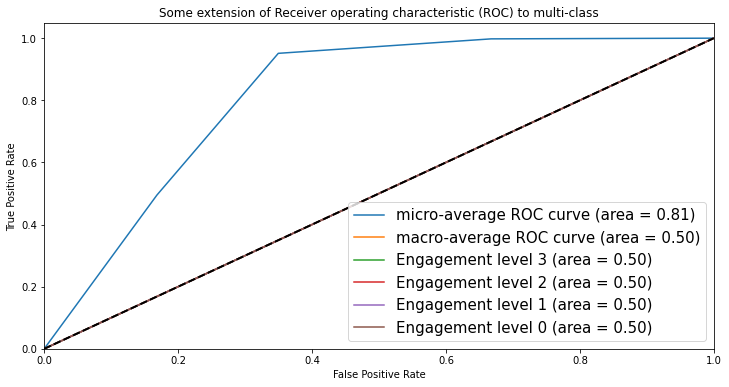

MSE =  0.13640267 |F1-score =  0.3277368277368278 |AUC-ROC =  0.5 
|AUC =  {0: 0.5, 1: 0.5, 2: 0.5, 3: 0.5, 'micro': 0.8146277590722035, 'macro': 0.5, 'weighted': 0.8146277590722035, 'sample': 0.8146277590722035}
(0.3277368277368278, 0.5)


In [12]:
print(evaluate_error(biLSTM_en_model,X_test, y_test, y_test_cat))

## K-Fold cross-validation

loss: 0.893975 accuracy: 0.495812 mse: 0.138116 auc_1: 0.808838


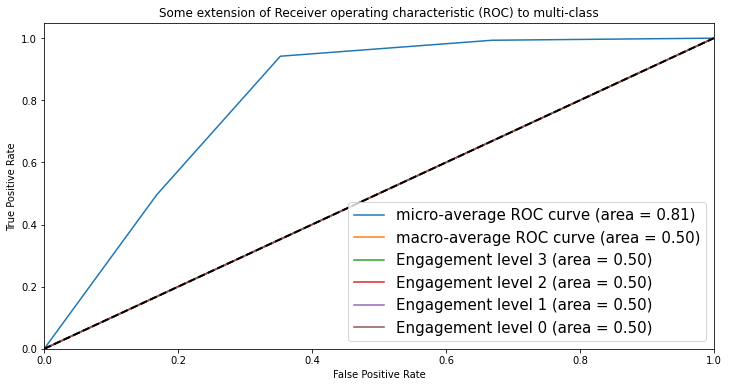

MSE =  0.1381163 |F1-score =  0.3286908600486569 |AUC-ROC =  0.5 
|AUC =  {0: 0.5, 1: 0.5, 2: 0.5, 3: 0.5, 'micro': 0.8103480364786897, 'macro': 0.5, 'weighted': 0.8103480364786897, 'sample': 0.8103480364786897}
loss: 0.895149 accuracy: 0.495254 mse: 0.138142 auc_2: 0.809333


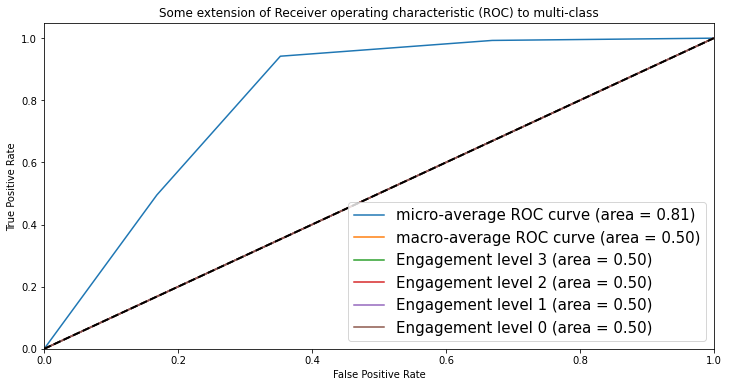

MSE =  0.13814187 |F1-score =  0.32807344330981936 |AUC-ROC =  0.5 
|AUC =  {0: 0.5, 1: 0.5, 2: 0.5, 3: 0.5, 'micro': 0.8099758049506793, 'macro': 0.5, 'weighted': 0.8099758049506793, 'sample': 0.8099758049506793}
loss: 0.892870 accuracy: 0.495531 mse: 0.138019 auc_3: 0.809413


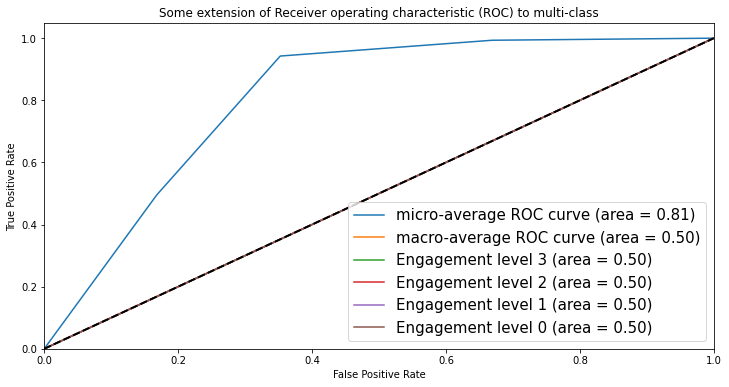

MSE =  0.13802117 |F1-score =  0.328379345677956 |AUC-ROC =  0.5 
|AUC =  {0: 0.5, 1: 0.5, 2: 0.5, 3: 0.5, 'micro': 0.8104283054003725, 'macro': 0.5, 'weighted': 0.8104283054003725, 'sample': 0.8104283054003725}
loss: 0.892869 accuracy: 0.495531 mse: 0.138019 auc_4: 0.810089


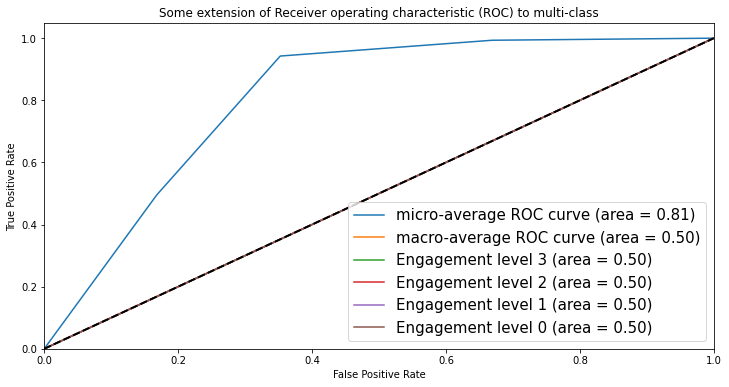

MSE =  0.1380196 |F1-score =  0.328379345677956 |AUC-ROC =  0.5 
|AUC =  {0: 0.5, 1: 0.5, 2: 0.5, 3: 0.5, 'micro': 0.8104283054003725, 'macro': 0.5, 'weighted': 0.8104283054003725, 'sample': 0.8104283054003725}
loss: 0.894083 accuracy: 0.495531 mse: 0.138130 auc_5: 0.809184


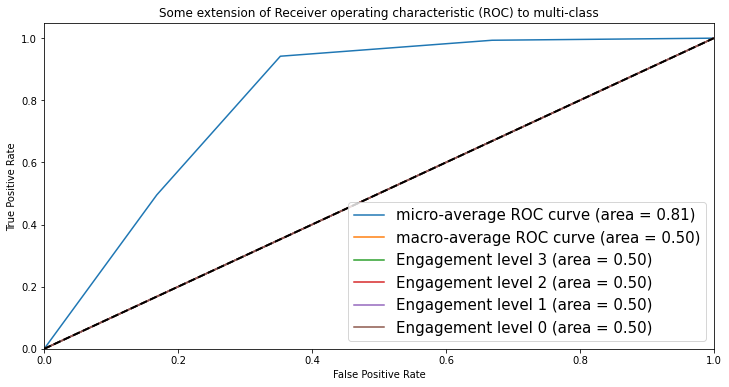

MSE =  0.13812867 |F1-score =  0.328379345677956 |AUC-ROC =  0.5 
|AUC =  {0: 0.5, 1: 0.5, 2: 0.5, 3: 0.5, 'micro': 0.8102420856610801, 'macro': 0.5, 'weighted': 0.8102420856610801, 'sample': 0.8102420856610801}
 Accuracy 0.495532 (+/- 0.000177) 
 F1-scores 0.328380 (+/- 0.000195) 
 AUC 0.809371 (+/- 0.000409) 
 AUC(Test) 0.500000 (+/- 0.000000) 
 MSE 0.138085 (+/- 0.000055)
Training time:7:28:32.708418


In [13]:
# STRATIFIED K-FOLD CROSS VALIDATION
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
kf = KFold(n_splits=5)

cvscores = []
MSEscores = []
AUCscores = []
f1scores = []
AUCscores_test = []

tic = datetime.now()
fold_no = 1
for train_index, val_index in skf.split(X,y):
    # print(f'---------------------------------Training for fold {fold_no}--------------------------------------------- ')
    biLSTM_en_model = biLSTM_en(X)
    compile_train(biLSTM_en_model, X[train_index], y_cat[train_index], X[val_index], y_cat[val_index]) 
    scores = biLSTM_en_model.evaluate(X[val_index], y_cat[val_index], verbose=0)
    
    # Generate generalization metrics
    print("%s: %f" % (biLSTM_en_model.metrics_names[0], scores[0]), 
    "%s: %f" % (biLSTM_en_model.metrics_names[1], scores[1]),
    "%s: %f" % (biLSTM_en_model.metrics_names[2], scores[2]),
    "%s: %f" % (biLSTM_en_model.metrics_names[3], scores[3]))
    cvscores.append(scores[1])
    MSEscores.append(scores[2])
    AUCscores.append(scores[3])

    # # Generate more metrics
    eval = evaluate_error(biLSTM_en_model,X[val_index], y[val_index], y_cat[val_index])
    f1scores.append(eval[0])
    AUCscores_test.append(eval[1])

    fold_no = fold_no + 1
 
print(" Accuracy %f (+/- %f) \n F1-scores %f (+/- %f) \n AUC %f (+/- %f) \n AUC(Test) %f (+/- %f) \n MSE %f (+/- %f)" % (np.mean(cvscores), np.std(cvscores), np.mean(f1scores), np.std(f1scores), np.mean(AUCscores), np.std(AUCscores), np.mean(AUCscores_test), np.std(AUCscores_test), np.mean(MSEscores), np.std(MSEscores)))
# print(" Accuracy %f (+/- %f) \n F1-scores %f (+/- %f) \n AUC %f (+/- %f) \n MSE %f (+/- %f)" % (np.mean(cvscores), np.std(cvscores), np.mean(f1scores), np.std(f1scores), np.mean(AUCscores), np.std(AUCscores), np.mean(MSEscores), np.std(MSEscores)))

time = datetime.now() - tic
print("Training time:{}".format(time))

## Evaluation Each Subject

In [ ]:
for i in range(0,40):
    # print(subjy.shape, subjx.shape)
    print(subj[i])
    print(evaluate_error(biLSTM_en_model,globals()[subjx[i]], globals()[subjy[i]]))

In [ ]:
for i in range(40,80):
    # print(subjy.shape, subjx.shape)
    print(subj[i])
    print(evaluate_error(biLSTM_en_model,globals()[subjx[i]], globals()[subjy[i]]))

In [ ]:
for i in range(80,113):
    # print(subjy.shape, subjx.shape)
    print(subj[i])
    print(evaluate_error(biLSTM_en_model,globals()[subjx[i]], globals()[subjy[i]]))